# 합성곱 신경망(CNN)
## 전체 구조
- 완전연결(fully-connected): 인접하는 계층의 모든 뉴런과 결합되어 있는 것을 의미한다.
- Affine 계층: 완전히 연결된 계층을 의미한다.

 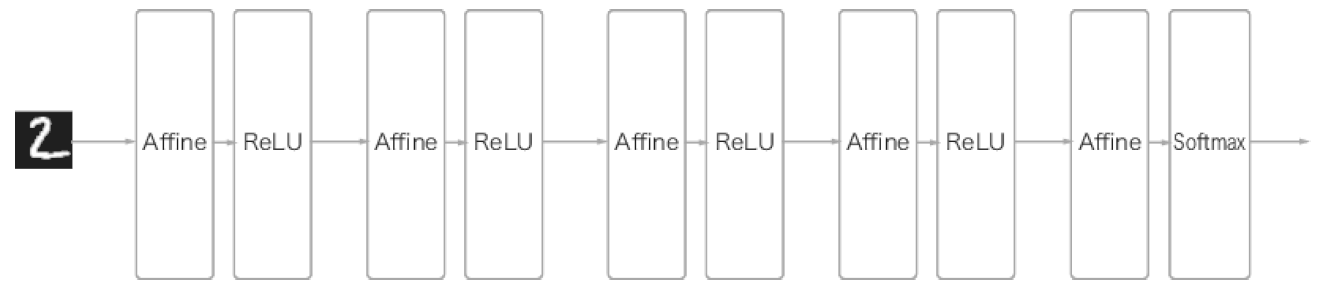

- CNN 구조
  - 합성곱 계층 Conv, 풀링 계층 Pooling이 추가
  - 출력에 가까운 층에서는 기존의 Affine-ReLU구성 사용
  - 마지막 출력 계층에서는 Affine-Softmax 조합을 사용한다.


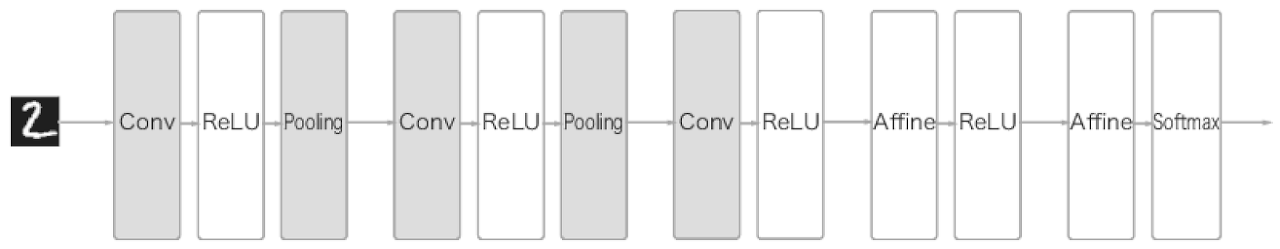

## 합성곱 계층
### 완전연결 계층의 문제점
- 인접하는 계층의 뉴런이 모두 연결되고 출력이 수는 임의로 정할 수 있다.
- 데이터의 형상이 무시된다. 즉 3차운 데이터가 1차운 데이터로 평탄화가 된다는 것이다.
- 모든 입력 데이터를 동등한 뉴런으로 취급하여 형상에 담긴 정보를 살릴 수 없다.
- 합성곱 계층에선느 형상을 유지하게 되는데 이를 통해 형상을 가진 데이터를 제대로 이해할 가능성이 있다.
- 합성곱 계층의 입출력 데이터를 특징 맵이라고 한다.

### 합성곱 연산
- 의미: 이미지 처리에서 말하는 필터 연산을 의미한다.
  - 필터: 커널이라고 말하기도 한다.
- 필터의 윈도우를 일정 간격으로 이동해가며 입력 데이터에 적용한다.
- 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구하게 되는데 이를 단일 곱셈-누산이라고 한다.
- 필터의 매개변수는 '가중치'를 말한다.

### 패딩
- 의미: 합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값으로 채운다.
- 출력 크기를 조정할 목적으로 사용한다.

### 스트라이드
- 필터를 적용하는 위치의 간격을 의미한다.
- 출력 크기 식
  - 입력 크기 (H, W)
  - 필터 크기 (FH, FW)
  - 패딩 P
  - 스트라이드 S

$$ OH = \frac{H + 2P - FH}{S} + 1 $$

$$ OW = \frac{W + 2P - FW}{S} + 1 $$

### 3차원 데이터의 합성곱 연산
- 3차원: 가로, 세로, 채널
- 입력 데이터의 채널 수와 필터 채널 수가 같아야 한다.

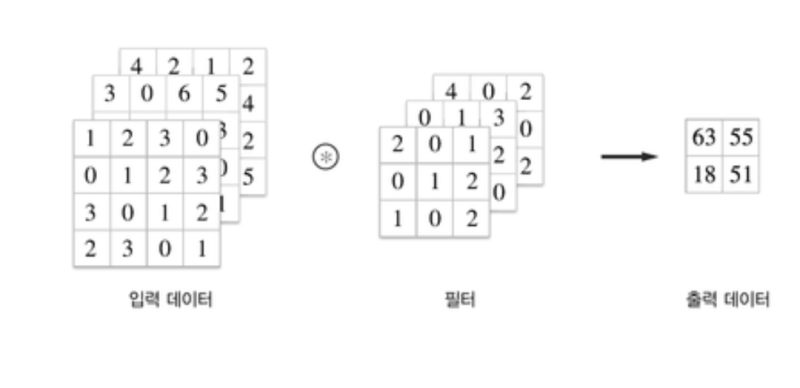

### 블록으로 생각하기
- 3차원의 합성곱 연산 방식
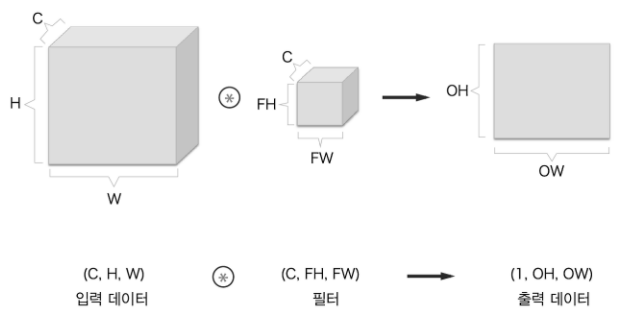

- 여러 필터를 사용한 합성곱 연산

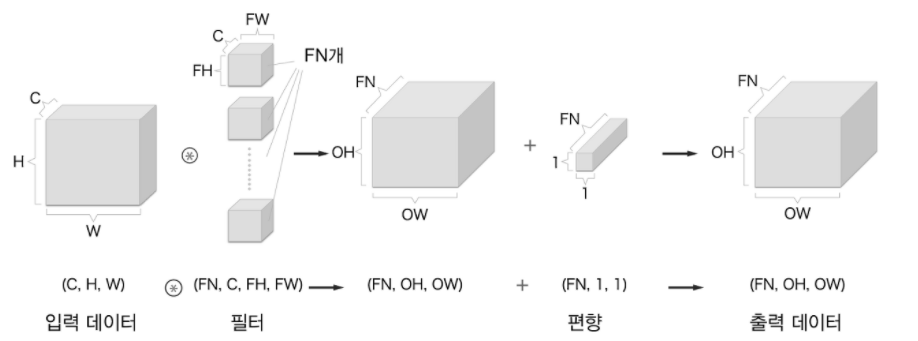

- 편향이 사용된 합성곱 연산

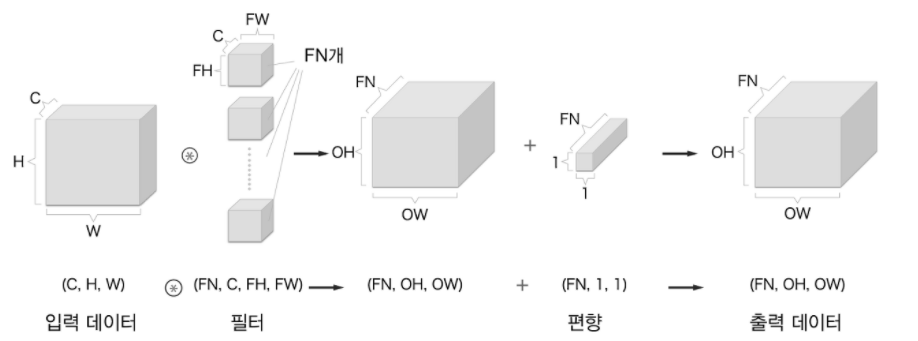

### 배치 처리
- 각 계층을 흐르는 데이터의 차원을 하나 늘려 4차원 데이터로 저장한다.
  - 데이터 수, 채널 수, 높이, 너비
- 데이터가 N개일 때 N회 분의 처리를 한번에 수행한다.

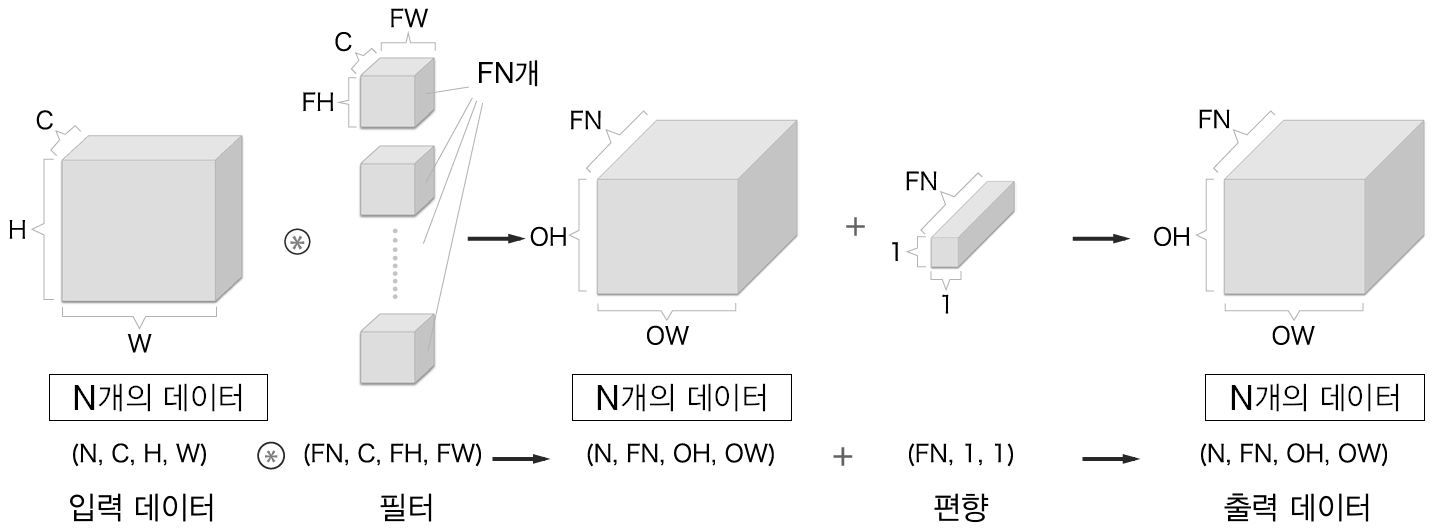

## 풀링 계층
- 풀링: 세로*가로 방향의 공간을 줄이는 연산
- 최대 풀링: 최댓값을 구하는 연산
### 풀링 계층의 특징
- 학습해야 할 매개변수가 없다.
- 채널 수가 변하지 않는다.
- 입력의 변화에 영향을 적게 받는다.(강건하다)

## 합성곱/풀링 계층 구현하기
### im2col로 데이터 전개하기
- 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는 함수이다.
- 3차원 입력 데이터는 2차원 행렬로 바뀐다.
- 메모리를 더 많이 소비한다는 단점이 존재
- 선형대수 라이브러리를 활용해 효율을 높일 수 있다.

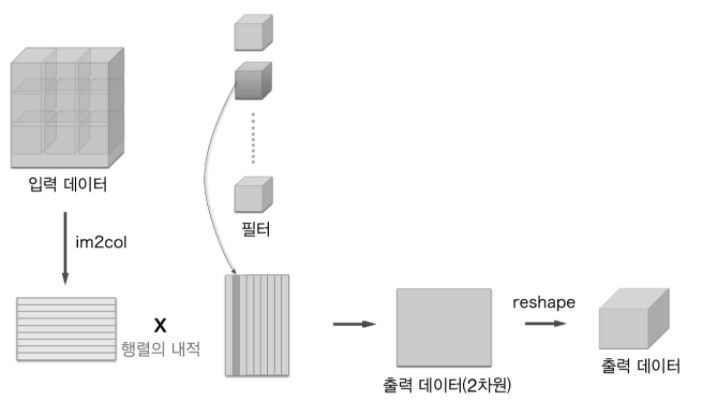

### 합성곱 계층 구현하기
- im2col 함수

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [ ]:
import sys, os
import numpy as np
sys.path.append(os.pardir)

x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


- im2col로 합성곱 계층 구현

In [ ]:
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int(1+(H+2*self.pad-FH)/self.stride)
    out_w = int(1+(W+2*self.pad-FW)/self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = self.W.reshape(FN, -1).T
    out = np.dot(col, col_W) + self.b

    out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)

    return out

  def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.

    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

### 풀링 계층 구현하기
- 합성곱 계층과 마찬가지로 im2col을 사용
- 풀링 적용 영역을 채널마다 독립적으로 전개한다.
- 전개한 행렬에서 행별 최댓값을 구하고 적절한 형상으로 성형한다.
- 전체 순서
  - 입력 데이터를 전개한다.
  - 행별 최댓값을 구한다.
  - 적절한 모양으로 성형한다.

In [1]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

## CNN 구현하기

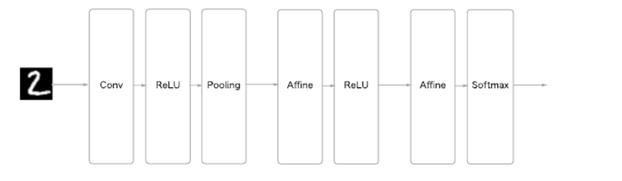

- SimpleConvNet 초기화
  - 초기화 인수로 주어진 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼낸다
  - 합성곱 계층의 출력 크기를 계산
- 가중치 매개변수를 초기화
  - 1번째 층의 합성곱 계층과 나머지 두 완전연결 계층의 가중치와 편향을 인스턴스 변수 params 딕셔너리에 저장
  - 2, 3번째 층 역시 가중치와 편향을 각각 키로 저장한다.
- CNN 구성하는 계층 생성
  - 순서가 있는 딕셔너리인 ㅣayer에 계층들을 차례로 추가
  - 마지막 SoftmaxWithLoss 계층은 last_layer라는 별도 변수에 저장
- 추론을 수행하는 predict 메서드, 손실 함수의 값을 구하는 loss메서드를 구현
 - predict 메서드: 초기화 때 layers에 추가한 계층을 맨 앞에서부터 차례로 forward 메서드 호출하며 그 결과를 다음 계층에 전달
 - loss 메서드: predict 메서드의 결과를 인수로 마지막 층의 forward 메서드를 호출
- grads라는 딕셔너리 변수에 각 가중치 매개변수의 기울기를 저장

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망

    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
train loss:0.00933324513009951
train loss:0.0025350181998198855
train loss:0.003334345665381047
train loss:0.0028657373181499267
train loss:0.000601290392113629
train loss:0.0003665116695539035
train loss:0.008023982904341653
train loss:0.0012823169139029658
train loss:0.021387605983307915
train loss:0.016577338125126528
train loss:0.004226750097812554
train loss:0.010024363472775681
train loss:0.0017487203300299695
train loss:0.01025485697579355
train loss:0.0008166963597649211
train loss:0.002935088399425437
train loss:0.007018188011007052
train loss:0.0005670458100660936
train loss:0.014022813522947757
train loss:0.002155902500058484
train loss:0.014792021563566396
train loss:0.0035438937608577104
train loss:0.004198857313334372
train loss:0.0010955521882822377
train loss:0.01984568679715297
train loss:0.00390699206997792
train loss:0.006464298293162552
train loss:0.007736970109412781
train loss:0.006437703162244573
train loss:0.002001583692051855

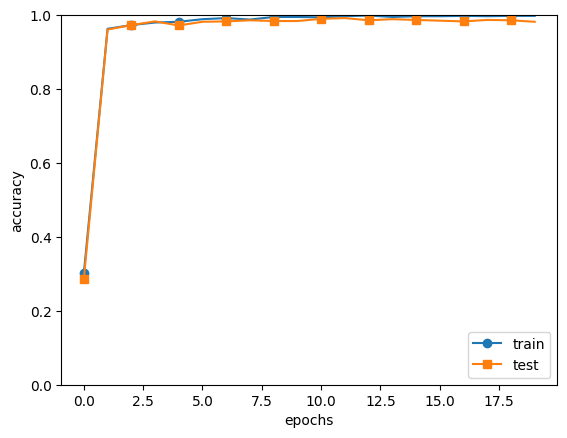

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## CNN 시각화하기
- 계층이 깊어질수록 추출되는 정보는 더 추상화된다.
  - 처음 층은 단순한 에지에 반응하고, 이후 텍스처 반응하고 더 복잡한 사물의 일부에 반응하도록 변화
  - 즉 사물의 '의미'를 이해하도록 변화한다
### 1번째 층의 가중치 시각화하기

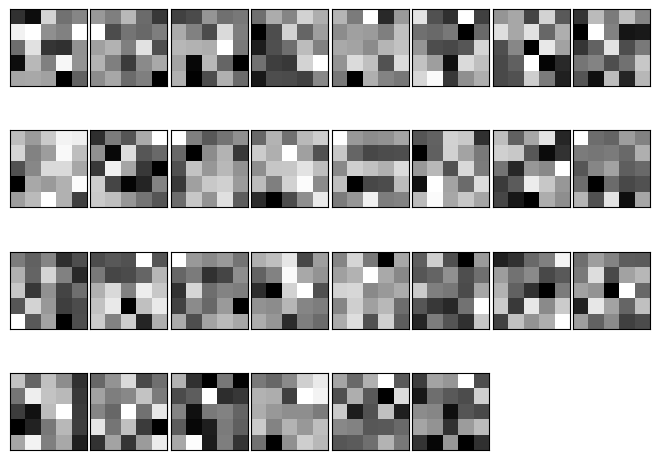

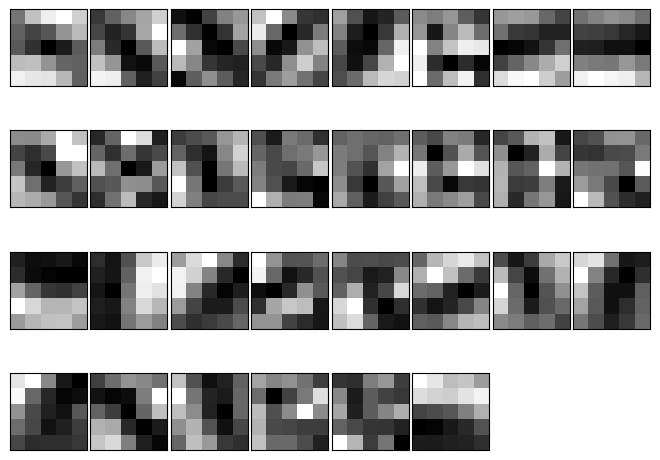

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

## 대표적인 CNN
- LeNet
  - 손글씨 숫자를 인식하는 네트워크
  - 합성곱 계층과 풀링계층을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력
  - 활성화함수로 시그모이드 함수를 사용한다.
  - 서브 샘플링을 하여 중간 데이터의 크기를 줄인다.
- AlexNet
  - 합성곱 계층과 풀링 계층을 거듭하며 마지막으로 완전연결 곛층을 거쳐 결과를 출력
  - 이전과의 변화 정리
    - 활성화함수로 ReLU를 이용한다.
    - LRN(Local Response Normalization)이라는 국소적 정규화를 실시하는 계층을 이용한다.
    - 드롭아웃을 사용한다.